imports
-----------

In [1]:
#standard library imports
import copy
import pylab
from sklearn.manifold import TSNE
import h5py
import scipy
import datetime
import math
import cmasher as cmr
from matplotlib.lines import Line2D
from matplotlib_venn import venn3
from scipy import linalg as LA
import glob
import yaml
from scipy.stats import linregress
import pandas as pd
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
np.random.seed(123456)
import pickle
import seaborn as sns
from scipy.spatial.distance import squareform
import warnings
from statistics import median
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from os.path import join, dirname, abspath
import os
import shutil
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, LeaveOneOut, RepeatedStratifiedKFold, KFold
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from tqdm.auto import tqdm
from matplotlib.gridspec import GridSpec
from scipy import stats

%matplotlib inline

In [2]:
from moseq2_viz.model.util import (relabel_by_usage, parse_model_results, compute_syllable_explained_variance)
from moseq2_app.gui.progress import update_progress, restore_progress_vars
from moseq2_viz.util import parse_index
from moseq2_viz.scalars.util import scalars_to_dataframe
from moseq2_viz.model.util import compute_behavioral_statistics
from moseq2_viz.util import read_yaml


Functions
----------

UMAP preprocessing and functions
--------------------

In [3]:
import warnings

# Binning / smoothing
    
def firing_rates(
    spike_times, 
    spike_labels, 
    window_size=0.2, 
    window_step=0.02
):
    """Convert spike tikes to firing rates using a sliding window
    
    Parameters
    ----------
    spike_times : ndarray
        Spike times (in seconds) for all units. The source of each spike is
        input separately using ``spike_labels``
        
    spike_labels: ndarray
        The source/label for each spike in ``spike_times``. The maximum
        value of this array determines the number of rows in the heatmap.
    
    window_size: float, default=0.2
        Length (in seconds) of the sliding window used to calculate firing rates
        
    window_step: float, default=0.02
        Step-size (in seconds) between each window used to calculate firing rates
    Returns
    -------
    firing_rates: ndarray
        Array of firing rates, where rows units and columns are sliding 
        window locations. ``firing_rates`` has shape ``(N,M)`` where::
            N = max(spike_labels)+1
            M = (max(spike_times)-min(spike_times))/binsize
    start_time, float
        The time (in seconds) corresponding to the left-boundary
        of the first window in ``firing_rates``.
    """
    # round spikes to window_step and factor our start time
    spike_times = np.around(spike_times/window_step).astype(int)
    start_time = spike_times.min()
    spike_times = spike_times - start_time
    
    # create heatmap of spike counts for each window_step-sized bin
    spike_labels = spike_labels.astype(int)
    heatmap = np.zeros((spike_labels.max()+1, spike_times.max()+1))
    np.add.at(heatmap, (spike_labels, spike_times), 1/window_step)
    
    # use convolution to get sliding window counts
    kernel = np.ones(int(window_size//window_step))/(window_size//window_step)
    for i in range(heatmap.shape[0]): heatmap[i,:] = np.convolve(heatmap[i,:],kernel, mode='same')
    return heatmap, start_time-window_step/2


def bin_data(
    data, 
    binsize,
    axis=-1,
    return_intervals=False
):
    """Bin data using non-overlaping windows along `axis`
    Returns
    -------
    data_binned: ndarray
    bin_intervals: ndarray (returned if ``rerturn_intervals=True``)
        (N,2) array with the start and end index of each bin
    """
    data = np.moveaxis(data,axis,-1)
    pad_amount = (-data.shape[-1])%binsize
    num_bins = int((data.shape[-1]+pad_amount)/binsize)

    data_padded = np.pad(data,[(0,0)]*(len(data.shape)-1)+[(0,pad_amount)])
    data_binned = data_padded.reshape(*data.shape[:-1], num_bins, binsize).mean(-1)
    if pad_amount > 0: data_binned[...,-1] = data_binned[...,-1] * binsize/(binsize-pad_amount)
    data_binned = np.moveaxis(data_binned,-1,axis)

    if return_intervals:
        bin_starts = np.arange(0,num_bins)*binsize
        bin_ends = np.arange(1,num_bins+1)*binsize
        bin_ends[-1] = data.shape[-1]
        bin_intervals = np.vstack((bin_starts,bin_ends)).T
        return data_binned, bin_intervals
    else: return data_binned



# Normalization

def zscore(data, axis=0, eps=1e-10):
    """
    Z-score standardize the data along ``axis``
    """
    mean = np.mean(data, axis=axis, keepdims=True)
    std = np.std(data, axis=axis, keepdims=True) + eps
    return (data-mean)/std


# Dimensionality reduction

def sort(
    data, 
    method='rastermap', 
    options={}
):
    """Compute neuron ordering that groups neurons with similar activity
    Parameters
    ----------
    data: ndarray
        Data matrix where rows are neurons and columns are time points
    method: {'rastermap'}
        Method to use for sorting (currently only rastermap is implemented)
    options: dict, default={}
        Sorting method-specific options.
        'rastermap'
            ``options`` will be passed as keyword arguments when initializing
            `rastermap.mapping.Rastermap <https://github.com/MouseLand/rastermap/blob/40867ce9a8b2850d76483890740c0dc10d6cb413/rastermap/mapping.py#L531>`_
    Returns
    -------
    ordering: ndarray
        Ordering index that can be used for sorting (see `numpy.argsort`)
    """
    valid_sort_methods = ['rastermap']
    if not method in valid_sort_methods:
        raise AssertionError(method+' is not a valid sort method. Must be one of '+repr(valid_sort_methods))
    if method=='rastermap':
        print('Computing row order with rastermap')
        from rastermap import mapping
        model = mapping.Rastermap(n_components=1).fit(data)
        return np.argsort(model.embedding[:,0])


def umap_embedding(
    data, 
    standardize=True,
    n_pcs=20, 
    n_components=2, 
    n_neighbors=100,
    random_state=42,
    **kwargs
):
    """Generate a 2D embedding of neural activity using UMAP. The function 
    generates the embedding in three steps:
        1. (Optionally) standardize (Z-score) the activity of each neuron
        2. Perform initial dimensionality reduction using PCA
        3. Run UMAP on the output of PCA
    Parameters
    ----------
    data: ndarray
        Array of neural activity where rows are neurons and columns are time points
    standardize: bool, default=True
        Whether to standardize (Z-score) the data prior to PCA
    n_pcs: int, default=20
        Number of principal components to use during PCA. If ``n_pcs=None``, the binned 
        data will be passed directly to UMAP
    n_components: int, default=2
        Dimensionality of the embedding
    n_neighbors: int, default=100
        Passed to UMAP (see `explanation of UMAP parameters <https://umap-learn.readthedocs.io/en/latest/parameters.html>`_).
    **kwargs
        Any other UMAP parameters can also be passed as keyword arguments
    Returns
    -------
    coodinates: ndarray
        (N,2) array containing UMAP coordinates
    """
    from sklearn.decomposition import PCA
    from umap import UMAP

    if standardize: data = zscore(data, axis=1)
    PCs = PCA(n_components=n_pcs).fit_transform(data.T)
    umap_obj = UMAP(n_neighbors=n_neighbors, n_components=n_components, n_epochs=500,random_state=random_state,**kwargs)
    coordinates = umap_obj.fit_transform(PCs)
    return coordinates

In [4]:
# upload data
warnings.simplefilter('ignore')
mean_df = pd.read_csv('/n/groups/datta/Dana/Estrous/mean_df.csv')
#scalar_df = pd.read_csv('/n/groups/datta/Dana/Estrous/scalar_df.csv')

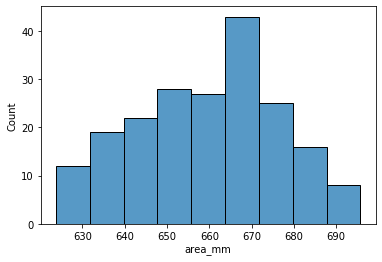

In [5]:
# remove bad sessions based on mouse size
area_df = mean_df.groupby(['group', 'SubjectName'])['area_mm'].mean()
sns.histplot(area_df)
mina = 600
maxa = 750

rearrrange data in structure
----------

In [6]:
# arrange all data in stcuture: 4 phases X 16 mice in each phase X n samples in session
groups = mean_df['group'].unique()
mic = mean_df['mouse'].unique()
sessions=[]
st=[]
dbg = []
mice=[]
mice_all=[]
phase=[]
phase_all=[]
rep = []
for indg, gp in enumerate(groups): # for all phases
    #print(gp)
    smic1=[]
    s1=[]
    m1=[]
    m11=[]
    ph1=[]
    ph11=[]
    rep1=[]
    for indm, mc in enumerate(mic): # for all mice
        smic2=[]
        s2=[]
        m2=[]
        ph2=[]
        rep2=[]
        curr = mean_df.loc[(mean_df['group']==gp) & (mean_df['mouse']==mc)] # find the current mouse in current phase
        #print(len(curr.syllable.unique()))
        cs=curr['SubjectName'].unique()
        for inds, ss in enumerate(cs):
            syl = curr.loc[curr['SubjectName']==ss]['usage'].values
            area = curr.loc[curr['SubjectName']==ss]['area_mm'].mean()
            if (area>mina) & (area<maxa):
                s2.append(ss)
                rep2.append(curr.loc[curr['SubjectName']==ss]['rep'].unique())
                smic2.append(syl)
                m2.append(mc)
                ph2.append(gp)
        if m2:
            #_, idx = np.unique(m2, return_index=True)
            #m1.append(list((m2[np.sort(idx)])))
            m1.append(list(np.unique(m2)))
            m11.append(list(m2))
            smic1.append(smic2)
            s1.append(s2)
            st.append(s2)
            rep1.append(rep2)
            #_, idx = np.unique(ph2, return_index=True)
            #ph1.append(list((ph2[np.sort(idx)])))
            ph1.append(list(np.unique(ph2)))
            ph11.append(list(ph2))
    mice.append(m1) # 4 phases X 16 mice 
    mice_all.append(m11) # 4 phases X 16 mice X number of times each mouse appears
    phase_all.append(ph11) # 4 phases X 16 mice X number of times each phase appears
    dbg.append(smic1) #syllable usages 4 phaes X 16 mice X sessions X 61 syllables 
    sessions.append(s1) # 4 phaes X 16 mice X sessions names
    phase.append(ph1) # 4 phaes X 16 mice X phase names
    rep.append(rep1) # 4 phaes X 16 mice X repetitions names
# sanity check
print(len(np.concatenate(np.concatenate(sessions))))
ind_sessions = np.concatenate(np.concatenate(sessions)) # list of all sessions included
ind_mice = np.concatenate(np.concatenate(mice))
ind_phase = np.concatenate(np.concatenate(phase))# lise of all mice included
ind_rep_all = np.concatenate(np.concatenate(rep))
ind_mice_all = np.concatenate(np.concatenate(mice_all))
ind_phase_all = np.concatenate(np.concatenate(phase_all))
len(dbg[0][1][0])

200


49

In [7]:
# arrange all data in stcuture: 4 phases X 16 mice in each phase X n samples in session
mic = sorted(mean_df['mouse'].unique())
rep = sorted(mean_df['rep'].unique())
groups = sorted(mean_df['group'].unique())

# matrix per mouse
msessions=[]
mdbg = []
mmice=[]
mrep = []
mphase=[]
for indm, mc in enumerate(mic): # for all mice
    s1=[]
    rep1=[]
    smic1=[]
    m1=[]
    phase1=[]
    curr=mean_df.loc[(mean_df['mouse']==mc)] # find the current mouse in current phase
    #sor=np.argsort(curr['rep'].unique(),axis=0)
    #cs=curr['SubjectName'].unique()[sor]
    cs=curr['SubjectName'].unique()
    for inds, ss in enumerate(cs): #all session for a mouse
            syl = curr.loc[curr['SubjectName']==ss]['usage'].values
            area = curr.loc[curr['SubjectName']==ss]['area_mm'].mean()
            if (area>mina) & (area<maxa):
                s1.append(ss) #session name
                rep1.append(int(curr.loc[curr['SubjectName']==ss]['rep'].unique())) #repetition number
                smic1.append(syl) #syllable usafe
                m1.append(mc) #mouse
                phase1.append(str(curr.loc[curr['SubjectName']==ss]['group'].unique())) #phase
    mmice.append(m1) # 16 mics X n sessions 
    mdbg.append(smic1) #syllable usages 16 mice X n sessions X 61 syllables 
    msessions.append(s1) # 16 mice X sessions names
    mrep.append(rep1) # 16 mice X repetitions names
    mphase.append(phase1)

# matrix per repetition
rsessions=[]
rdbg = []
rmice=[]
rrep = []
rphase=[]
for indm, mc in enumerate(rep): # for all repetitions
    s1=[]
    rep1=[]
    smic1=[]
    m1=[]
    phase1=[]
    curr=mean_df.loc[(mean_df['rep']==mc)] # find all mice in current repetition
    #sor=np.argsort(curr['mouse'].unique(),axis=0)
    #cs=curr['SubjectName'].unique()[sor]
    cs=curr['SubjectName'].unique()
    for inds, ss in enumerate(cs): #all session for a mouse
            syl = curr.loc[curr['SubjectName']==ss]['usage'].values
            s1.append(ss) #session name
            rep1.append(int(curr.loc[curr['SubjectName']==ss]['rep'].unique())) #repetition number
            smic1.append(syl) #syllable usafe
            m1.append(str(curr.loc[curr['SubjectName']==ss]['mouse'].unique())) #mouse
            phase1.append(str(curr.loc[curr['SubjectName']==ss]['group'].unique())) #phase
    rmice.append(m1) # 16 mics X n sessions 
    rdbg.append(smic1) #syllable usages 16 mice X n sessions X 61 syllables 
    rsessions.append(s1) # 16 mice X sessions names
    rrep.append(rep1) # 16 reprtitions X mouse names
    rphase.append(phase1)
    
# matrix per phase
psessions=[]
pdbg = []
pmice=[]
prep = []
pphase=[]
for indm, mc in enumerate(groups): # for all repetitions
    s1=[]
    rep1=[]
    smic1=[]
    m1=[]
    phase1=[]
    curr=mean_df.loc[(mean_df['group']==mc)] # find all rep in current repetition
    cs=curr['SubjectName'].unique()
    for inds, ss in enumerate(cs): #all session for a mouse
            syl = curr.loc[curr['SubjectName']==ss]['usage'].values
            s1.append(ss) #session name
            rep1.append(int(curr.loc[curr['SubjectName']==ss]['rep'].unique())) #repetition number
            smic1.append(syl) #syllable usafe
            m1.append(str(curr.loc[curr['SubjectName']==ss]['mouse'].unique())) #mouse
            phase1.append(str(curr.loc[curr['SubjectName']==ss]['group'].unique())) #phase
    pmice.append(m1) # 16 mics X n sessions 
    pdbg.append(smic1) #syllable usages 16 mice X n sessions X 61 syllables 
    psessions.append(s1) # 16 mice X sessions names
    prep.append(rep1) # 16 reprtitions X mouse names
    pphase.append(phase1)

In [8]:
#Keep only the average syll for each mouse for each phase
frequencies_bg=[]
for indg, gp in enumerate(dbg):
    ftemp=[]
    for indm, ms in enumerate(gp):
        ftemp.append(np.nanmean(np.array(ms),axis=0))
    frequencies_bg.append(ftemp)

In [9]:
len(mean_df.uuid.unique())

200

# ----------------------------------------------------------------------- 
# ANALYSIS
# -----------------------------------------------------------------------

In [10]:
# plot/colors definitions
from matplotlib.lines import Line2D
import matplotlib as mpl
rep_labels = np.unique(np.concatenate(mrep))
mouse_labels = np.unique(np.concatenate(mmice))
group_labels = list(np.unique(np.concatenate(mphase)))
max_sylls=len(dbg[0][1][0])

# save figures
data_loc="/n/groups/datta/Dana/"+'estrous_figs_new2/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass
os.chdir(data_loc)

plt.style.use("seaborn-paper")
'''
[‘Solarize_Light2’, ‘_classic_test_patch’, ‘bmh’, ‘classic’, 
 ‘dark_background’, ‘fast’, ‘fivethirtyeight’, ‘ggplot’,’grayscale’,’seaborn’,’seaborn-bright’,
 ’seaborn-colorblind’, ‘seaborn-dark’, ‘seaborn-dark-palette’, ‘seaborn-darkgrid’, ‘seaborn-deep’, 
 ‘seaborn-muted’, ‘seaborn-notebook’, ‘seaborn-paper’, ‘seaborn-pastel’, ‘seaborn-poster’,’seaborn-talk’,
 ’seaborn-ticks’,’seaborn-white’,’seaborn-whitegrid’,’tableau-colorblind10′]
 '''

'\n[‘Solarize_Light2’, ‘_classic_test_patch’, ‘bmh’, ‘classic’, \n ‘dark_background’, ‘fast’, ‘fivethirtyeight’, ‘ggplot’,’grayscale’,’seaborn’,’seaborn-bright’,\n ’seaborn-colorblind’, ‘seaborn-dark’, ‘seaborn-dark-palette’, ‘seaborn-darkgrid’, ‘seaborn-deep’, \n ‘seaborn-muted’, ‘seaborn-notebook’, ‘seaborn-paper’, ‘seaborn-pastel’, ‘seaborn-poster’,’seaborn-talk’,\n ’seaborn-ticks’,’seaborn-white’,’seaborn-whitegrid’,’tableau-colorblind10′]\n '

UMAP
-----------

# Umap based on bootstraping and applied to data

In [11]:
'''
# prepare copy of mean_df
plot_df = mean_df[mean_df.group.str.contains('long')].copy()
plot_df['group']= plot_df['group'].str.split('_', expand = True)[1]
temp_mean_df = plot_df.groupby(by = ['mouse', 'group','rep', 'syllable']).mean()['usage'].reset_index()
mean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['group','rep', 'mouse'], columns=['syllable']).reset_index().fillna(0)
newf=[]
yr=[]
yp=[]
ti=100

# bootstrap
for i in range(ti):
    for choose in mouse_labels:
        curr = mean_df_lc[mean_df_lc['mouse'] == choose]
        btrain = curr.groupby('group').apply(lambda x: x.sample(n=1,replace=True)).reset_index(drop=True) # new balanced df
                #print(btrain)
        currf = btrain.drop(['group','rep', 'mouse'], axis=1).to_numpy()
        newf.append(currf)
        y = btrain['group'].to_numpy()
        ya = btrain['rep'].to_numpy()
        yp.append(y)
        yr.append(ya)
'''

"\n# prepare copy of mean_df\nplot_df = mean_df[mean_df.group.str.contains('long')].copy()\nplot_df['group']= plot_df['group'].str.split('_', expand = True)[1]\ntemp_mean_df = plot_df.groupby(by = ['mouse', 'group','rep', 'syllable']).mean()['usage'].reset_index()\nmean_df_lc = pd.pivot_table(temp_mean_df, values='usage', index=['group','rep', 'mouse'], columns=['syllable']).reset_index().fillna(0)\nnewf=[]\nyr=[]\nyp=[]\nti=100\n\n# bootstrap\nfor i in range(ti):\n    for choose in mouse_labels:\n        curr = mean_df_lc[mean_df_lc['mouse'] == choose]\n        btrain = curr.groupby('group').apply(lambda x: x.sample(n=1,replace=True)).reset_index(drop=True) # new balanced df\n                #print(btrain)\n        currf = btrain.drop(['group','rep', 'mouse'], axis=1).to_numpy()\n        newf.append(currf)\n        y = btrain['group'].to_numpy()\n        ya = btrain['rep'].to_numpy()\n        yp.append(y)\n        yr.append(ya)\n"

In [12]:
'''
# umap fit on bootstapped data, transform real data
from umap import UMAP
n_pcs=None 
n_components=2
n_neighbors=20

newfrequencies = np.concatenate(newf)
data = newfrequencies.T
data = zscore(data, axis=1)
PCs = PCA(n_components=n_pcs).fit_transform(data.T)
umap_obj = UMAP(n_neighbors=n_neighbors, n_components=n_components, n_epochs=500).fit(PCs)

frequencies = np.concatenate(mdbg)
data = frequencies.T
data = zscore(data, axis=1)
PCs = PCA(n_components=n_pcs).fit_transform(data.T)
coordinates = umap_obj.transform(PCs)
'''

'\n# umap fit on bootstapped data, transform real data\nfrom umap import UMAP\nn_pcs=None \nn_components=2\nn_neighbors=20\n\nnewfrequencies = np.concatenate(newf)\ndata = newfrequencies.T\ndata = zscore(data, axis=1)\nPCs = PCA(n_components=n_pcs).fit_transform(data.T)\numap_obj = UMAP(n_neighbors=n_neighbors, n_components=n_components, n_epochs=500).fit(PCs)\n\nfrequencies = np.concatenate(mdbg)\ndata = frequencies.T\ndata = zscore(data, axis=1)\nPCs = PCA(n_components=n_pcs).fit_transform(data.T)\ncoordinates = umap_obj.transform(PCs)\n'

plot by individuals 3D
--------------

In [13]:
'''
# variables to plot
from mpl_toolkits.mplot3d import Axes3D
factor=1
cmap2 = mpl.cm.tab20

# set the colors for the plot
age_labels = mouse_labels
color_mat=[]
custom_lines=[]
from collections import Counter
counts = Counter(sorted(np.concatenate(mmice))).values()
c=0
for i in counts:
    for j in range(i):
        color_mat.append(cmap2(c*factor))
    c=c+1
_,idx=np.unique(color_mat, axis=0,return_index=True)
lcol = np.array(color_mat)[np.sort(idx)]
for indc, col in enumerate(lcol):
    custom_lines.append(Line2D([0], [0], color=col, lw=4)) 
    

# sort frequencies by mouse
frequencies = np.concatenate(mdbg)

# umap
for i in ([7,12,14,18,24,26,30]):
    coordinates = umap_embedding(frequencies.T, 
        standardize=True,
        n_pcs=None, 
        n_components=3, 
        n_neighbors=8,
        random_state=i)

    fig = plt.figure()
    fig.set_size_inches(10,10) 
    ax = fig.add_subplot(projection='3d')
    plt.legend(handles=custom_lines,labels=list(age_labels),bbox_to_anchor=(1.2, 1))
    plt.title('Umap colored by mouse'+str(i),fontsize=20)
    #plt.xlabel('LD1',fontsize=20)
    #plt.ylabel('LD2',fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.patch.set_facecolor('white')
    for j in range(len(coordinates)):
        ax.scatter(coordinates[j][0],coordinates[j][1],coordinates[j][2],color=color_mat[j],s=50)
    plt.show()
'''

"\n# variables to plot\nfrom mpl_toolkits.mplot3d import Axes3D\nfactor=1\ncmap2 = mpl.cm.tab20\n\n# set the colors for the plot\nage_labels = mouse_labels\ncolor_mat=[]\ncustom_lines=[]\nfrom collections import Counter\ncounts = Counter(sorted(np.concatenate(mmice))).values()\nc=0\nfor i in counts:\n    for j in range(i):\n        color_mat.append(cmap2(c*factor))\n    c=c+1\n_,idx=np.unique(color_mat, axis=0,return_index=True)\nlcol = np.array(color_mat)[np.sort(idx)]\nfor indc, col in enumerate(lcol):\n    custom_lines.append(Line2D([0], [0], color=col, lw=4)) \n    \n\n# sort frequencies by mouse\nfrequencies = np.concatenate(mdbg)\n\n# umap\nfor i in ([7,12,14,18,24,26,30]):\n    coordinates = umap_embedding(frequencies.T, \n        standardize=True,\n        n_pcs=None, \n        n_components=3, \n        n_neighbors=8,\n        random_state=i)\n\n    fig = plt.figure()\n    fig.set_size_inches(10,10) \n    ax = fig.add_subplot(projection='3d')\n    plt.legend(handles=custom_line

plot by individuals 2D
--------------

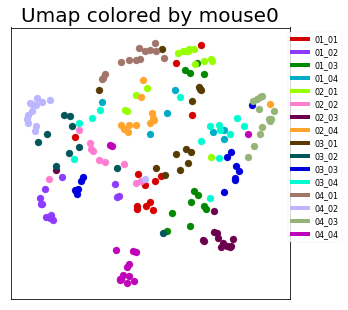

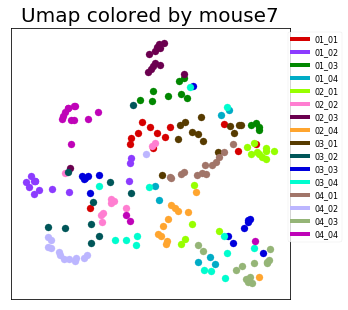

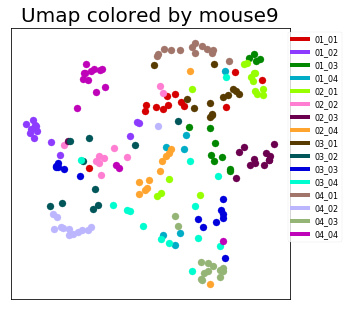

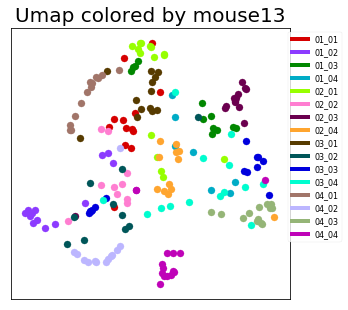

In [14]:
# variables to plot
from mpl_toolkits.mplot3d import Axes3D
factor=1
cmap2 = mpl.cm.tab20
import colorcet as cc
cmap2 = cc.glasbey

# set the colors for the plot
age_labels = mouse_labels
color_mat=[]
custom_lines=[]
from collections import Counter
counts = Counter(sorted(np.concatenate(mmice))).values()
c=0
for i in counts:
    for j in range(i):
        color_mat.append(cmap2[c*factor])
    c=c+1
_,idx=np.unique(color_mat, axis=0,return_index=True)
lcol = np.array(color_mat)[np.sort(idx)]
for indc, col in enumerate(lcol):
    custom_lines.append(Line2D([0], [0], color=col, lw=4)) 
    

# sort frequencies by mouse
frequencies = np.concatenate(mdbg)
# if you want to log transform
frequencies = np.log(frequencies + 1e-6)

# umap
for i in ([0,7,9,13]):
    coordinates = umap_embedding(frequencies.T, 
        standardize=True,
        n_pcs=None, 
        n_components=2, 
        n_neighbors=8,
        random_state=i)

    fig, ax = plt.subplots()
    fig.set_size_inches(5,5) 
    plt.legend(handles=custom_lines,labels=list(age_labels),bbox_to_anchor=(1.2, 1))
    plt.title('Umap colored by mouse'+str(i),fontsize=20)
    #plt.xlabel('LD1',fontsize=20)
    #plt.ylabel('LD2',fontsize=20)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.patch.set_facecolor('white')
    for j in range(len(coordinates)):
        ax.scatter(coordinates[j][0],coordinates[j][1],color=color_mat[j],s=50)
    plt.show()

In [19]:
# sort frequencies by mouse
frequencies = np.concatenate(mdbg)
coordinates = umap_embedding(frequencies.T, 
        standardize=True,
        n_pcs=None, 
        n_components=2, 
        n_neighbors=8,
        random_state=0)

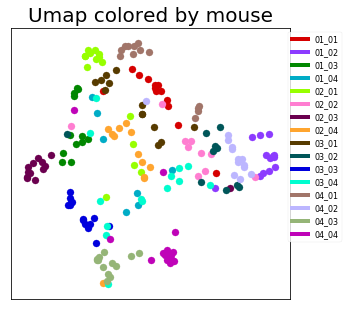

In [20]:
# variables to plot
max_syllable=60
factor=1
cmap2 = mpl.cm.tab20
import colorcet as cc
cmap2 = cc.glasbey

# set the colors for the plot
age_labels = mouse_labels
color_mat=[]
custom_lines=[]
from collections import Counter
counts = Counter(sorted(np.concatenate(mmice))).values()
c=0
for i in counts:
    for j in range(i):
        color_mat.append(cmap2[c*factor])
    c=c+1
_,idx=np.unique(color_mat, axis=0,return_index=True)
lcol = np.array(color_mat)[np.sort(idx)]
for indc, col in enumerate(lcol):
    custom_lines.append(Line2D([0], [0], color=col, lw=4)) 
    
fig, ax = plt.subplots()
fig.set_size_inches(5,5)  
plt.legend(handles=custom_lines,labels=list(age_labels),bbox_to_anchor=(1.2, 1))
plt.title('Umap colored by mouse',fontsize=20)
#plt.xlabel('LD1',fontsize=20)
#plt.ylabel('LD2',fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
    

for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=color_mat[i], s=50)

#plt.scatter(coordinates[:][0],coordinates[1],c=[cc.glasbey[mouse_map[m]] for m in mice], s=50)
    
#fig.savefig(data_loc + 'umap_individual_new.pdf', bbox_inches='tight')

# color with clusters

In [ ]:
import numpy as np
import pandas as pd
import colorcet as cc
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# umap coords
coords = coordinates
# mouse id
mice = np.concatenate(mmice)
mouse_map = dict(map(reversed, enumerate(np.unique(mice))))

# cluster id
clusters = clust_labels_indv
df = pd.DataFrame(data=np.concatenate((coords, clusters[:, None], mice[:, None]), axis=1), columns=['umap1', 'umap2', 'cluster', 'mice'])
df = df.astype({'umap1': float, 'umap2': float, 'cluster': int})

fig = plt.figure()
ax = fig.gca()
fig1 = plt.figure()
ax1 = fig1.gca()

padding = 1
npoints = 7

for cluster, _df in df.groupby('cluster'):
    x = _df['umap1']
    y = _df['umap2']
    xmu = np.mean(x)
    ymu = np.mean(y)
    x -= xmu
    y -= ymu
    to_remove = (x**2 + y**2).sort_values()

    
    x = x[to_remove.index[:-1]].to_numpy()
    y = y[to_remove.index[:-1]].to_numpy()
    
    U, S, V = np.linalg.svd(np.vstack((x, y)))
    freq_mouse = _df['mice'].map(mouse_map).mode().iloc[0]
    angle = np.rad2deg(np.arctan2(U[1, 0], U[0, 0]))
    e = Ellipse(xy=(xmu, ymu), width=S[0] * padding, height=S[1] * padding, angle=angle, fc=cc.glasbey[cluster], alpha=0.2)
    ax.add_artist(e)
    e = Ellipse(xy=(xmu, ymu), width=S[0] * padding, height=S[1] * padding, angle=angle, fc=cc.glasbey[cluster], alpha=0.2)
    ax1.add_artist(e)

ax1.scatter(df['umap1'], df['umap2'], c=[cc.glasbey[mouse_map[m]] for m in mice])
ax1.set(title='dots colored by mouse')
ax.scatter(df['umap1'], df['umap2'], c=[cc.glasbey[c] for c in df['cluster']])
ax.set(title='dots colored by cluster')
plt.show()

plot by clustering algorithm labels
-----------

In [ ]:
# variables to plot
max_syllable=60
factor=80
cmap2 = mpl.cm.rainbow
factor=16
custom_lines=[]

# set the colors for the plot
labels = clust_labels_indv
age_labels = np.unique(clust_labels_indv)
for i in range(len(age_labels)):
    custom_lines.append(Line2D([0], [0], color=cmap2(i*factor), lw=4)) 

fig, ax = plt.subplots()
fig.set_size_inches(5,5)  
plt.legend(handles=custom_lines,labels=list(age_labels),bbox_to_anchor=(1.2, 1))
plt.title('Umap colored by mouse clustering algorithm',fontsize=20)
#plt.xlabel('LD1',fontsize=20)
#plt.ylabel('LD2',fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
    
for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=custom_lines[labels[i]].get_color(), s=50)
fig.savefig(data_loc + 'umap_clusters_indv_new.pdf', bbox_inches='tight')

In [24]:
phasec = ['#CE3045','#EF7C32','#FFDD00','#939598']
custom_lines=[]
i=0
custom_lines.append(Line2D([0], [0], color=phasec[i], lw=4))

plot by phase
---------------------

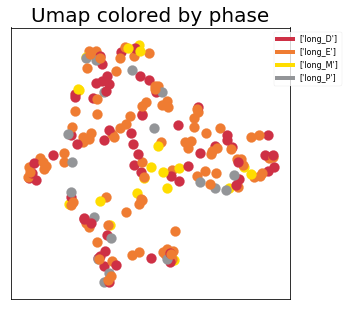

In [25]:
# variables to plot
max_syllable=60
factor=5
import colorcet as cc
cmap2 = cc.glasbey_warm
custom_lines=[]

phasec = ['#CE3045','#EF7C32','#FFDD00','#939598']

# set the colors for the plot
age_labels = group_labels
for i in range(len(age_labels)):
    custom_lines.append(Line2D([0], [0], color=phasec[i], lw=4))
le = LabelEncoder()
le.fit(np.unique(np.concatenate(mphase)))
y = le.transform(np.concatenate(mphase))
    
fig, ax = plt.subplots()
fig.set_size_inches(5,5)  
plt.legend(handles=custom_lines,labels=list(age_labels),bbox_to_anchor=(1.2, 1))
plt.title('Umap colored by phase',fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
    
for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=custom_lines[y[i]].get_color(), s=100)
fig.savefig(data_loc + 'umap_phase_new.pdf', bbox_inches='tight')

plot by phase clustering
-----------

In [ ]:
# variables to plot
max_syllable=60
factor=80
cmap2 = mpl.cm.gnuplot
custom_lines=[]

# set the colors for the plot
labels = clust_labels_phase
age_labels = list(np.unique(clust_labels_phase))
for i in range(len(age_labels)):
    custom_lines.append(Line2D([0], [0], color=cmap2(i*factor), lw=4)) 

fig, ax = plt.subplots()
fig.set_size_inches(5,5)  
plt.legend(handles=custom_lines,labels=age_labels,bbox_to_anchor=(1.2, 1))
plt.title('Umap colored by clustering algorithm',fontsize=20)
#plt.xlabel('LD1',fontsize=20)
#plt.ylabel('LD2',fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
    
for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=custom_lines[labels[i]].get_color(), s=100)
fig.savefig(data_loc + 'umap_clusters_phase_new.pdf', bbox_inches='tight')

plot by repetition
---------------------

In [ ]:
# to color by phase
# create array of labels of phases
# variables to plot
factor=16
cmap2 = mpl.cm.rainbow
age_labels = rep_labels
custom_lines=[]
import colorcet as cc
cmap2 = cc.CET_C8

# set the colors for the plot
for i in range(len(age_labels)):
    custom_lines.append(Line2D([0], [0], color=cmap2[i*factor], lw=4)) 
le = LabelEncoder()
le.fit(np.unique(np.concatenate(mrep)))
y = le.transform(np.concatenate(mrep))
    
fig, ax = plt.subplots()
fig.set_size_inches(5,5)  
plt.legend(handles=custom_lines,labels=list(age_labels),bbox_to_anchor=(1.2, 1))
plt.title('Umap colored by phase',fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
    
for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=custom_lines[y[i]].get_color(), s=100)
fig.savefig(data_loc + 'umap_rep_new.pdf', bbox_inches='tight')

plot by rep clustering
-----------

In [ ]:
labels = clust_labels_rep
age_labels = list(np.unique(clust_labels_rep))
# variables to plot

# to color by phase
# create array of labels of phases
# variables to plot
factor=1
cmap2 = mpl.cm.tab20
custom_lines=[]

# set the colors for the plot
for i in range(len(age_labels)):
    custom_lines.append(Line2D([0], [0], color=cmap2(i*factor), lw=4)) 

fig, ax = plt.subplots()
fig.set_size_inches(5,5)  
plt.legend(handles=custom_lines,labels=age_labels,bbox_to_anchor=(1.2, 1))
plt.title('Umap colored by clustering algorithm',fontsize=20)
#plt.xlabel('LD1',fontsize=20)
#plt.ylabel('LD2',fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
    
for i in range(len(coordinates)):
    plt.scatter(coordinates[i][0],coordinates[i][1],color=custom_lines[labels[i]].get_color(), s=100)
fig.savefig(data_loc + 'umap_clusters_rep_new.pdf', bbox_inches='tight')